[INFO] YOLO took 1.846238 seconds


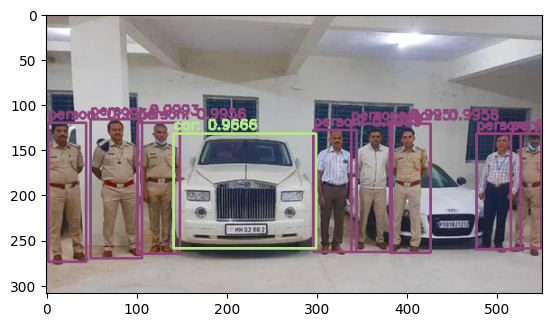

In [ ]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import os


FILE_NAME = 'prc0.jpg'
INPUT_FILE='data/' + FILE_NAME
# OUTPUT_FILE='predicted.jpg'
LABELS_FILE='data/coco.names'
CONFIG_FILE='cfg/yolov3.cfg'
WEIGHTS_FILE='yolov3.weights'
CONFIDENCE_THRESHOLD=0.5

LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")


net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

image = cv2.imread(INPUT_FILE)
(H, W) = image.shape[:2]

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]



blob = cv2.dnn.blobFromImage(image, 1/ 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()


print("[INFO] YOLO took {:.6f} seconds".format(end - start))


# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE_THRESHOLD:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, CONFIDENCE_THRESHOLD)

# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        color = [int(c) for c in COLORS[classIDs[i]]]

        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# save the output image in project directory
try:
    if not os.path.exists("outputs/"):
        os.makedirs("outputs/")
    cv2.imwrite("outputs/" + FILE_NAME + ".png", image)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
# cv2.imwrite("example.png", image)
# show the image output
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [2]:
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

INPUT_FILE='data/new york short.mp4'
OUTPUT_FILE='output.avi'
LABELS_FILE='data/coco.names'
CONFIG_FILE='cfg/yolov3.cfg'
WEIGHTS_FILE='yolov3.weights'
CONFIDENCE_THRESHOLD=0.5

H=None
W=None




LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")


net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

vs = cv2.VideoCapture(INPUT_FILE)

# getting video width and height and cast to int
vw = int(vs.get(3))
vh = int(vs.get(4))


fps = FPS().start()

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30, (vw, vh), True)


# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

while True:
    try:
        (grabbed, image) = vs.read()
    except:
        break
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    if W is None or H is None:
        (H, W) = image.shape[:2]
    layerOutputs = net.forward(ln)


    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > CONFIDENCE_THRESHOLD:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, CONFIDENCE_THRESHOLD)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[classIDs[i]]]

            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # show the output image
    cv2.imshow("output", image)
#     writer.write(cv2.resize(image,(800, 600)))
    writer.write(image)
    fps.update()
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# do a bit of cleanup
fps.stop()
cv2.destroyAllWindows()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
